In [2]:
# Imports

import cv2
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Declare preprocessing functions
img_size = 64
def get_label(file_path: str):
    parsed = tf.strings.split(file_path, os.path.sep)
    parent = parsed[-2]
    file_name = parsed[-1]
    if parent == "PNEUMONIA":
        label_str = tf.strings.split(file_name, '_')[1]
    else:
        label_str = parent
    return tf.argmax(label_str == class_names)


def decode_img(img):
    
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, dtype= tf.dtypes.uint8)

    # Check the number of channels
    num_channels = tf.shape(img)[-1]

    # Convert RGB to grayscale if necessary
    if num_channels == 3:
        img = tf.image.rgb_to_grayscale(img)
    # get image dimensions
    img_shape = tf.shape(img).numpy()

    width, height = img_shape[0], img_shape[1]
    min_dimension = tf.math.minimum(width, height).numpy()

    crop_size = tf.constant([min_dimension, min_dimension, 1], dtype='int32')
    # Implement random cropping
    img = tf.image.random_crop(value=img, size=crop_size)
    img = tf.cast(img, tf.uint8)  # Explicitly cast to uint8
    return tf.image.resize(img, [img_size, img_size], method='nearest', preserve_aspect_ratio=False)


@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.uint8)
    return img, label

In [4]:
# Preprocessing

# path_to_dir = os.environ.get("DATASET_PATH")
path_to_dir = "/Volumes/KINGSTON/Pnemonia Dataset/chest_xray"
if path_to_dir is None:
    os.environ["DATASET_PATH"] = input("Enter complete path to the chest_xray folder: ")
    path_to_dir = os.environ["DATASET_PATH"]
    print("You should set the DATASET_PATH enviroment variable to avoid this every time you run the program.")

ds_files = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("**/[!._]*.jpeg")]

list_ds = tf.data.Dataset.from_tensor_slices(ds_files)
image_count = len(ds_files)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

for f in list_ds.take(5):
    print(f.numpy())

class_names = np.array(['NORMAL', 'bacteria', 'virus'])

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)



b'/Volumes/KINGSTON/Pnemonia Dataset/chest_xray/test/NORMAL/IM-0045-0001.jpeg'
b'/Volumes/KINGSTON/Pnemonia Dataset/chest_xray/train/PNEUMONIA/person1679_bacteria_4450.jpeg'
b'/Volumes/KINGSTON/Pnemonia Dataset/chest_xray/train/PNEUMONIA/person972_virus_1646.jpeg'
b'/Volumes/KINGSTON/Pnemonia Dataset/chest_xray/train/NORMAL/IM-0480-0001.jpeg'
b'/Volumes/KINGSTON/Pnemonia Dataset/chest_xray/train/PNEUMONIA/person51_bacteria_242.jpeg'


Image shape:  (64, 64, 1)
Label:  1
Label Shape:  ()
Type:  bacteria


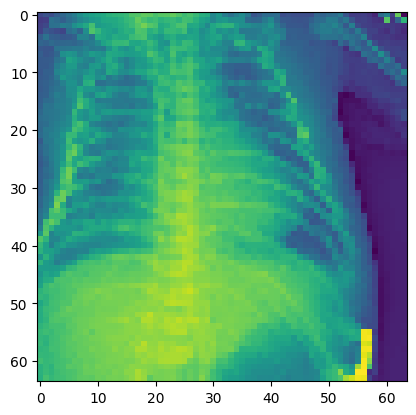

Image shape:  (64, 64, 1)
Label:  2
Label Shape:  ()
Type:  virus


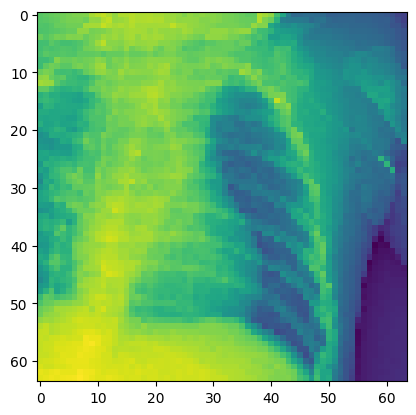

Image shape:  (64, 64, 1)
Label:  2
Label Shape:  ()
Type:  virus


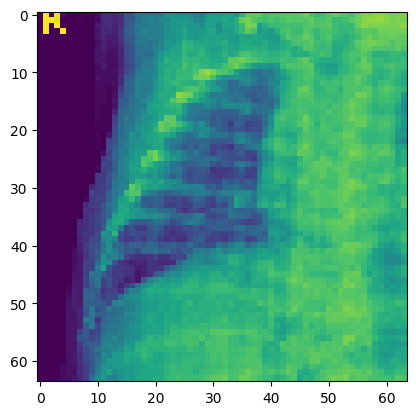

In [5]:
# View sample of dataset

for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label Shape: ", label.numpy().shape)
    print("Type: ", class_names[label.numpy()])
    plt.imshow(image.numpy())
    plt.show()



In [6]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

Training set size:  4704
Validation set size:  1184
147
Epoch 1/10
147/147 [==============================] - 32s 215ms/step - loss: 0.5683 - accuracy: 0.7599 - val_loss: 0.4783 - val_accuracy: 0.8438
Epoch 2/10
147/147 [==============================] - 33s 224ms/step - loss: 0.5612 - accuracy: 0.7607 - val_loss: 0.5858 - val_accuracy: 0.7500
Epoch 3/10
147/147 [==============================] - 37s 250ms/step - loss: 0.5533 - accuracy: 0.7686 - val_loss: 0.4081 - val_accuracy: 0.8750
Epoch 4/10
147/147 [==============================] - 45s 304ms/step - loss: 0.5429 - accuracy: 0.7755 - val_loss: 0.4310 - val_accuracy: 0.8438
Epoch 5/10
147/147 [==============================] - 42s 288ms/step - loss: 0.5379 - accuracy: 0.7725 - val_loss: 0.6285 - val_accuracy: 0.7188
Epoch 6/10
147/147 [==============================] - 44s 298ms/step - loss: 0.5501 - accuracy: 0.7669 - val_loss: 0.4674 - val_accuracy: 0.8125
37/37 - 9s - loss: 0.4961 - accuracy: 0.7771 - 9s/epoch - 251ms/step


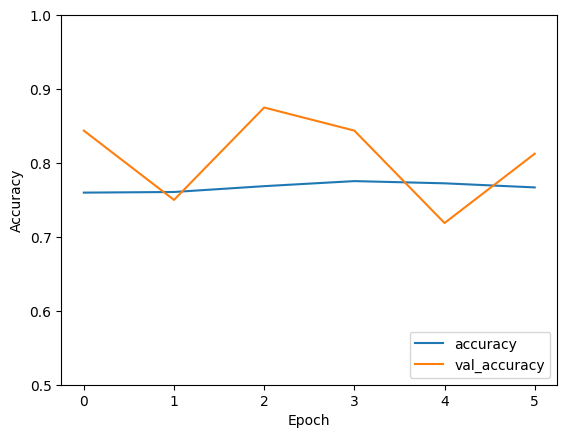

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.load_weights("xray_model.keras")
# Batching
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print('Training set size: ', len(train_ds)*batch_size)
print('Validation set size: ', len(val_ds)*batch_size)

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Define number of epochs and steps per epoch
epochs = 10
steps_per_epoch = len(train_ds) # // batch_size
validation_steps = len(val_ds) // batch_size  # Assuming batch_size is defined

print(steps_per_epoch)


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)


In [8]:
model.save("xray_model_post_train.keras")